# analyze the effect of evolutional information (profile, local structure prediction)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.float_format = '{:.3f}'.format
plt.rcParams["figure.dpi"] = 150
sns.set(style='darkgrid')
from IPython.display import display
from pathlib import Path
from sklearn import metrics

## compare local structure between native and predicted

### compare secondary structure

In [2]:
# get observed ss
def get_observed_ss(file_path):
    ss_dict = {'H': 0, 'G': 0, 'I': 0, 'E': 1, 'B': 1, 'b': 1, 'T': 2, 'C': 2}
    with open(file_path, 'r') as f:
        lines = [line.split() for line in f.readlines()]
        lines = list(filter(lambda x: x[0] == 'ASG', lines))
        ss = np.array([[line[3], ss_dict[line[5]]] for line in lines], dtype=np.int32)
        df = pd.DataFrame({'resnum': ss[:, 0], 'native_ss': ss[:, 1]})
        return df

# get predicted local structure
def get_predicted_ss(file_path):
    ss_dict = {'H': 0, 'G': 0, 'I': 0, 'E': 1, 'B': 1, 'b': 1, 'T': 2, 'C': 2}
    with open(file_path, 'r') as f:
        lines = f.readlines()[1].strip()
        ss = np.array([[i + 1, ss_dict[line]] for i, line in enumerate(lines)], dtype=np.int32)
        df = pd.DataFrame({'resnum': ss[:, 0], 'pre_ss': ss[:, 1]})
        return df

def get_ss(target_name):
    ob_path = (Path('../native_local') / target_name).with_suffix('.ss')
    pre_path = (Path('../profile') / target_name / target_name).with_suffix('.ss')
    ob_ss = get_observed_ss(str(ob_path))
    pre_ss = get_predicted_ss(str(pre_path))
    df = pd.merge(ob_ss, pre_ss, on='resnum', how='inner')
    return df

In [3]:
get_ss('T1024')

,resnum,native_ss,pre_ss
0,2,2,2
1,3,0,2
2,4,0,0
3,5,0,2
4,6,0,2
...,...,...,...
386,402,0,0
387,403,0,0
388,404,0,2
389,405,0,2


### compare rsa

In [4]:
# get observed rsa
def get_observed_rsa(file_path):
    with open(file_path, 'r') as f:
        lines = [line.split() for line in f.readlines()]
        lines = list(filter(lambda x: x[0] == 'RES', lines))
        rsa = np.array([[line[2], -1] if line[4] == '  N/A' else [line[2], float(line[4])] for line in lines])
        df = pd.DataFrame({'resnum': rsa[:, 0], 'native_rsa': rsa[:, 1]})
        return df

# get predicted rsa
def get_predicted_rsa(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()[1].strip().split()
        rsa = np.array([[i + 1, r] for i, r in enumerate(lines)])
        df = pd.DataFrame({'resnum': rsa[:, 0], 'pre_rsa': rsa[:, 1]})
        return df

def get_rsa(target_name):
    ob_path = (Path('../native_local') / target_name).with_suffix('.rsa')
    pre_path = (Path('../profile') / target_name / target_name).with_suffix('.acc20')
    ob_rsa = get_observed_rsa(str(ob_path))
    pre_rsa = get_predicted_rsa(str(pre_path))
    df = pd.merge(ob_rsa, pre_rsa, on='resnum', how='inner')
    df = df.astype(np.float32)
    df['resnum'] = df['resnum'].astype(np.int32)
    return df

In [5]:
get_rsa('T1024')

,resnum,native_rsa,pre_rsa
0,2,57.500,65.000
1,3,51.100,50.000
2,4,46.800,10.000
3,5,31.200,45.000
4,6,90.300,65.000
...,...,...,...
386,402,31.300,40.000
387,403,63.500,50.000
388,404,85.300,55.000
389,405,61.500,55.000


0.0033427148360672954


<AxesSubplot:xlabel='native_rsa', ylabel='pre_rsa'>

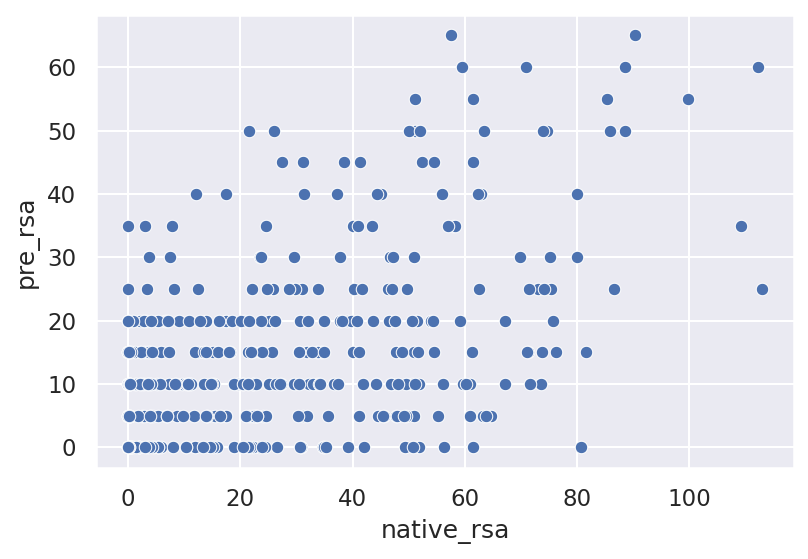

In [6]:
sdf = get_rsa('T1024')
print(metrics.r2_score(np.array(sdf['native_rsa']), np.array(sdf['pre_rsa'])))
sns.scatterplot(data=sdf, x='native_rsa', y='pre_rsa')

In [7]:
native_pdb_dir = Path('../native')
df_array = []
for target in native_pdb_dir.glob('*.pdb'):
    target = target.stem
    try:
        ss, rsa = get_ss(target), get_rsa(target)
    except FileNotFoundError:
        print(target)
    else:
        df = pd.merge(ss, rsa, on='resnum', how='outer')
        df['Target'] = target
        df_array.append(df)
local_df = pd.concat(df_array)

T1044


In [8]:
local_df.to_csv('../data/casp14_local_structure.csv')

In [9]:
metrics.accuracy_score(local_df['native_ss'], local_df['pre_ss'])

0.775480907263853

In [10]:
metrics.confusion_matrix(local_df['native_ss'], local_df['pre_ss'])

array([[2071,  119,  442],
       [  81, 1172,  375],
       [ 305,  242, 2159]])

In [11]:
metrics_array = []
for name, group in local_df.groupby('Target'):
    ss_acc = metrics.accuracy_score(group['native_ss'], group['pre_ss'])
    rsa_mae = metrics.mean_absolute_error(group['native_rsa'], group['pre_rsa'])
    rsa_r2_score = metrics.r2_score(group['native_rsa'], group['pre_rsa'])
    metrics_array.append([name, ss_acc, rsa_mae, rsa_r2_score])

In [12]:
target_local_df = pd.DataFrame(metrics_array, columns=['Target', 'ss_acc', 'rsa_mae', 'rsa_r2'])
target_local_df.to_csv('../data/casp14_local_structure_target.csv')
target_local_df

,Target,ss_acc,rsa_mae,rsa_r2
0,T1024,0.908,18.201,0.003
1,T1025,0.918,12.647,0.543
2,T1026,0.603,20.076,0.028
3,T1027,0.667,24.202,0.009
4,T1029,0.736,20.126,0.035
5,T1030,0.773,15.751,0.318
6,T1031,0.632,21.275,0.291
7,T1032,0.794,19.867,0.095
8,T1033,0.790,15.997,0.355
9,T1035,0.657,21.084,-0.035


## get psiblast result

In [13]:
from Bio import SearchIO
def read_blast_xml(file_path, iteration=2):
    query_result = list(SearchIO.parse(file_path, 'blast-xml'))[iteration - 1]
    return query_result

In [14]:
import math
def read_query_result(query_result):
    hit_num = len(query_result)
    mean_log_evalue = np.mean([hit[0].evalue for hit in query_result])
    return hit_num, mean_log_evalue

In [15]:
xml_dir = Path('../profile/blast')
result_array = []
for xml in xml_dir.glob('*.xml'):
    target = xml.stem
    query_result = read_blast_xml(xml)
    hit_num, mean_log_evalue = read_query_result(query_result)
    result_array.append([target, hit_num, mean_log_evalue])
blast_df = pd.DataFrame(result_array, columns=['Target', 'hit_num', 'mean_evalue']) 
blast_df

,Target,hit_num,mean_evalue
0,T1087,36,1.765
1,T1091,500,0.000
2,T1033,26,1.576
3,T1098,500,0.000
4,T1064,37,1.955
...,...,...,...
78,T1053,268,1.359
79,T1072s1,447,1.492
80,T1076,500,0.000
81,T1090,454,0.265


In [16]:
target_evol_df = pd.merge(target_local_df, blast_df, on='Target', how='outer').sort_values('Target')
target_evol_df

,Target,ss_acc,rsa_mae,rsa_r2,hit_num,mean_evalue
0,T1024,0.908,18.201,0.003,500,0.000
1,T1025,0.918,12.647,0.543,500,0.000
2,T1026,0.603,20.076,0.028,23,0.943
3,T1027,0.667,24.202,0.009,26,0.666
70,T1028,nan,nan,nan,500,0.000
...,...,...,...,...,...,...
42,T1096,nan,nan,nan,8,0.080
35,T1098,nan,nan,nan,500,0.000
32,T1099,0.835,23.806,-0.285,446,0.158
67,T1100,nan,nan,nan,500,0.000


In [17]:
target_evol_df.to_csv('../data/casp14_evolutional_info.csv')